In [57]:
!pip install -U monai==1.1.0 torch simpleitk matplotlib tqdm


[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


In [58]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import SimpleITK as sitk
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from monai.networks.nets import UNet
from torchvision.models.video import r3d_18
from scipy.ndimage import label, find_objects

In [59]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#  Image Loading

In [60]:
def load_ct_patch_as_tensor(path, size=64):
    img = sitk.ReadImage(path)
    arr = sitk.GetArrayFromImage(img).astype(np.float32)  # (Z,Y,X)

    # UNET normalization
    arr = np.clip(arr, -1000, 400)
    arr = (arr + 1000) / 1400

    t = torch.tensor(arr).unsqueeze(0).unsqueeze(0)  # (1,1,Z,Y,X)
    Z, Y, X = t.shape[-3:]

    padZ = max(0, size - Z)
    padY = max(0, size - Y)
    padX = max(0, size - X)

    t = F.pad(t, (0,padX, 0,padY, 0,padZ), value=0)
    t = t[:, :, :size, :size, :size]

    return t, arr  # tensor + original numpy (before crop/pad)

# Unet Helpers

In [61]:
def get_bbox_from_mask(mask):
    labeled, num = label(mask)
    if num == 0:
        return None
    sizes = [(labeled == i).sum() for i in range(1, num+1)]
    largest = np.argmax(sizes) + 1
    obj = find_objects(labeled == largest)[0]
    z1,z2 = obj[0].start, obj[0].stop
    y1,y2 = obj[1].start, obj[1].stop
    x1,x2 = obj[2].start, obj[2].stop
    return (z1,z2, y1,y2, x1,x2)


def compute_diameter_mm(mask, spacing=(1.0,1.0,1.0)):
    voxels = np.sum(mask > 0)
    if voxels == 0:
        return 0.0
    voxel_volume_mm3 = spacing[0] * spacing[1] * spacing[2]
    volume_mm3 = voxels * voxel_volume_mm3
    return ( (6 * volume_mm3 / np.pi) ** (1/3) )


def compute_confidence(pred_prob, mask):
    if mask.sum() == 0:
        return 0.0
    mean_prob = float(pred_prob[mask > 0].mean())
    hard_pred = (pred_prob > 0.5).astype(float)
    intersection = (hard_pred * mask).sum()
    union = hard_pred.sum() + mask.sum()
    dice = (2 * intersection) / (union + 1e-8)
    return 0.5 * mean_prob + 0.5 * dice


def predict_unet(unet_model, img_tensor):
    with torch.no_grad():
        pred = unet_model(img_tensor.to(DEVICE))
        pred_prob = torch.sigmoid(pred).cpu().numpy()[0,0]

    mask = (pred_prob > 0.5).astype(np.uint8)
    bbox = get_bbox_from_mask(mask)
    diameter = compute_diameter_mm(mask)
    confidence = compute_confidence(pred_prob, mask)

    return pred_prob, mask, bbox, diameter, confidence

# ResNet Helpers

In [62]:
# -----------------------------------------------------------
#            RESNET CLASSIFICATION HELPERS
# -----------------------------------------------------------
LABELS = {
    2: "ground-glass",
    1: "part-solid",
    0: "solid"
}

def build_resnet(num_classes=3, pretrained=False):
    model = r3d_18(pretrained=pretrained)
    old_conv = model.stem[0]
    new_conv = nn.Conv3d(
        1, old_conv.out_channels,
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        bias=False
    )
    if pretrained:
        new_conv.weight.data = old_conv.weight.data.mean(dim=1, keepdim=True)
    model.stem[0] = new_conv

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model


def classify_resnet(model, img_np):
    # ResNet uses zero-mean normalization
    norm = (img_np - img_np.mean()) / (img_np.std() + 1e-8)
    t = torch.from_numpy(norm).unsqueeze(0).unsqueeze(0).float().to(DEVICE)

    with torch.no_grad():
        logits = model(t)
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()

    idx = int(np.argmax(probs))
    return LABELS[idx], float(probs[idx])


# Unified Inference

In [63]:
# -----------------------------------------------------------
#                 UNIFIED VISUALIZATION
# -----------------------------------------------------------
def visualize_combined(image_np, bbox, unet_conf, unet_diam, resnet_label, resnet_prob):
    mid = image_np.shape[0] // 2
    img_slice = image_np[mid]

    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    ax.imshow(img_slice, cmap="gray")
    ax.set_title("UNet + ResNet Inference")

    if bbox is not None:
        z1,z2, y1,y2, x1,x2 = bbox

        rect = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=2,
            edgecolor='yellow',
            facecolor='none'
        )
        ax.add_patch(rect)

        text = (
            f"UNet Conf: {unet_conf*100:.1f}%\n"
            f"Diameter: {unet_diam:.2f} mm\n"
            f"ResNet: {resnet_label} ({resnet_prob*100:.1f}%)"
        )

        ax.text(
            x1, y1 - 5,
            text,
            color="yellow",
            fontsize=12,
            backgroundcolor="black"
        )

    plt.show()


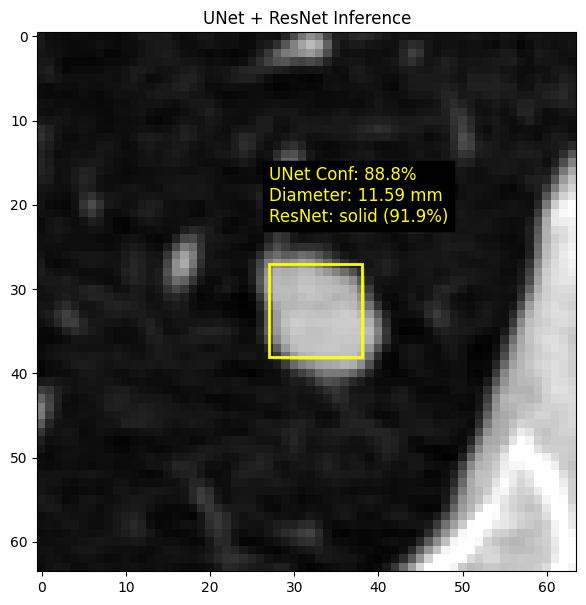

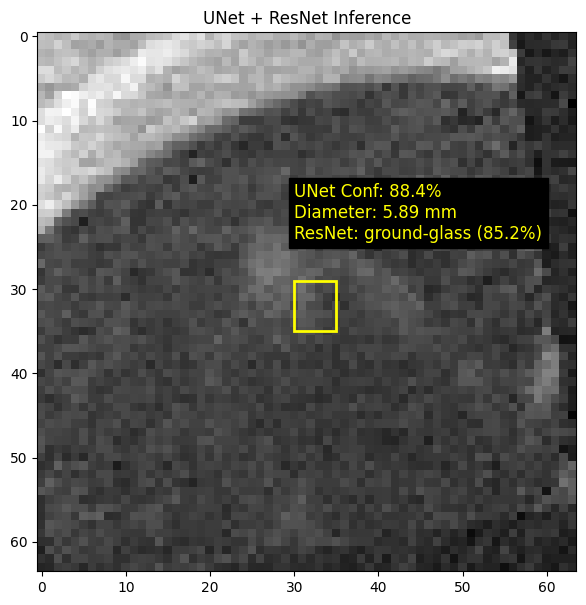

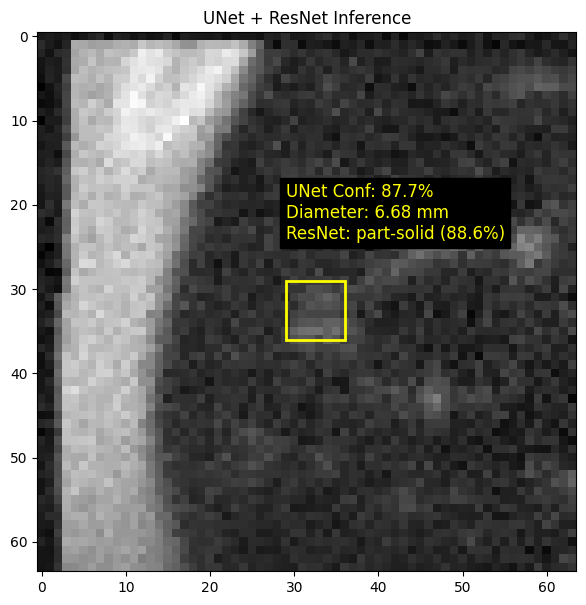

In [79]:

# -----------------------------------------------------------
#                      MAIN PIPELINE
# -----------------------------------------------------------
def run_inference(IMAGE_PATH):

    # ---------- Load UNet ----------
    unet = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=1,
        channels=(16,32,64,128),
        strides=(2,2,2),
        num_res_units=2
    ).to(DEVICE)

    ckpt = torch.load("../models/3d_unet/unet_best.pt", map_location=DEVICE)
    unet.load_state_dict(ckpt["model_state_dict"])
    unet.eval()

    # ---------- Load ResNet ----------
    resnet = build_resnet(pretrained=False).to(DEVICE)
    ckpt2 = torch.load("../models/3d_resnet/best_resnet.pth", map_location=DEVICE)
    if "model_state" in ckpt2:
        resnet.load_state_dict(ckpt2["model_state"])
    elif "model_state_dict" in ckpt2:
        resnet.load_state_dict(ckpt2["model_state_dict"])
    else:
        resnet.load_state_dict(ckpt2)
    resnet.eval()

    # ---------- Load Image ----------
    img_tensor, img_np = load_ct_patch_as_tensor(IMAGE_PATH)

    # ---------- UNet inference ----------
    pred_prob, mask, bbox, diam, unet_conf = predict_unet(unet, img_tensor)

    # ---------- ResNet inference ----------
    resnet_label, resnet_prob = classify_resnet(resnet, img_np)

    # ---------- Visualization ----------
    visualize_combined(
        img_np,
        bbox,
        unet_conf,
        diam,
        resnet_label,
        resnet_prob
    )


# -----------------------------------------------------------
# RUN
# -----------------------------------------------------------
if __name__ == "__main__":
    solid = "../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279_6001_321465552859463184018938648244_0886.nii.gz"
    ground_glass = "../dataset/augmented/ground-glass/1.3.6.1.4.1.14519.5.2.1.6279.6001.283733738239331719775105586296_aug_0398.nii.gz"
    part_solid ="../dataset/augmented/part-solid/1.3.6.1.4.1.14519.5.2.1.6279.6001.114914167428485563471327801935_aug_0202.nii.gz"
    for image in [solid,ground_glass,part_solid]:
        run_inference(image)